## Machine learning session 2: Decomposition
**4D-STEM data analysis workshop**
**NTNU, Trondheim, June 11, 2024** - by Tina Bergh


In [1]:
%matplotlib inline

In [2]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import hyperspy.api as hs
import pyxem as pxm

In [3]:
folder = '.\\'
file = 'SPED_Ag'
file_ending = '.hspy'

In [4]:
s = hs.load(folder+file+file_ending)

In [5]:
s.axes_manager

Navigation axis name,size,index,offset,scale,units
x,208,0,0.0,20.372,nm
y,64,0,0.0,20.372,nm
Signal axis name,size,,offset,scale,units
kx,112,,-1.4967850176908926,0.02672830388733737,$A^{-1}$
ky,112,,-1.4967850176908926,0.02672830388733737,$A^{-1}$


Plot the signal. The specimen is a silver lamella prepared by focused ion beam (FIB) lift-out. You can see a nanocrystalline Pt protection layer at the top and faceted silver grains further down.

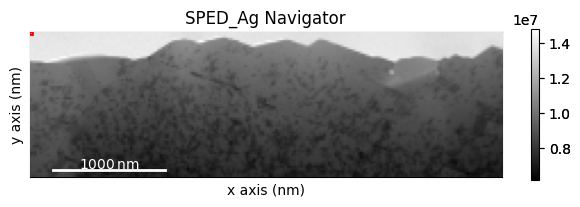

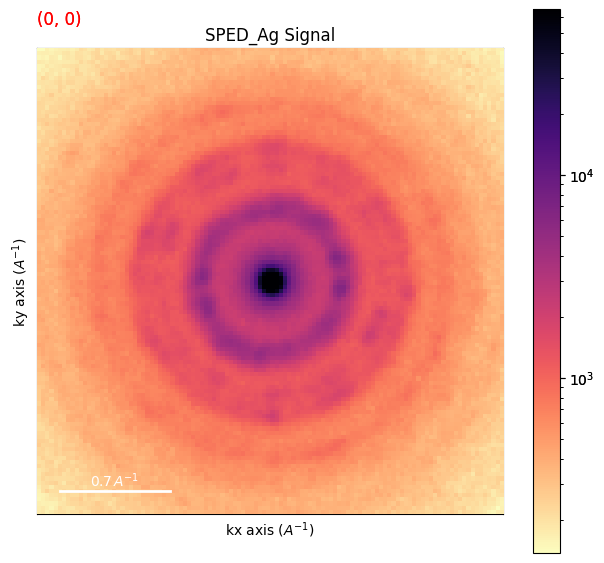

In [6]:
s.plot(norm='log', cmap='magma_r')

# Integrate the signal

Integrate the signal azimuthally to get a 1D diffraction pattern (similar to powder X-ray diffraction). Specify the number of pixels in the resulting integrated signal.

[########################################] | 100% Completed | 4.51 ss


<ElectronDiffraction1D, title: , dimensions: (208, 64|64)>

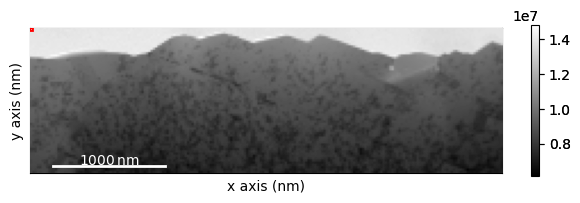

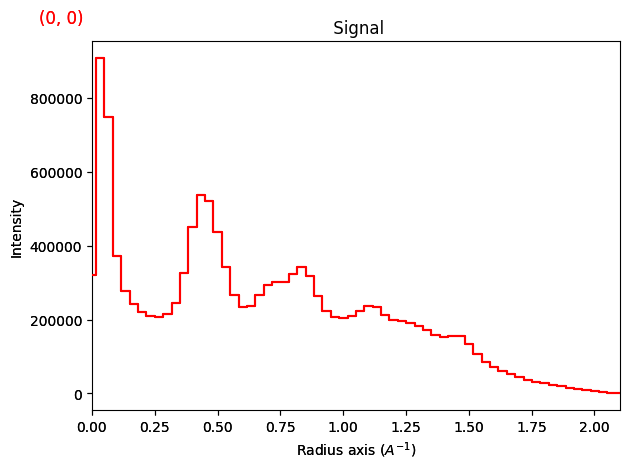

In [7]:
s_rad = s.get_azimuthal_integral1d(64)
s_rad.plot()
s_rad

Plot the maximum signal and inspect where the interesting features are with respect to the x-axis (scattering angle).

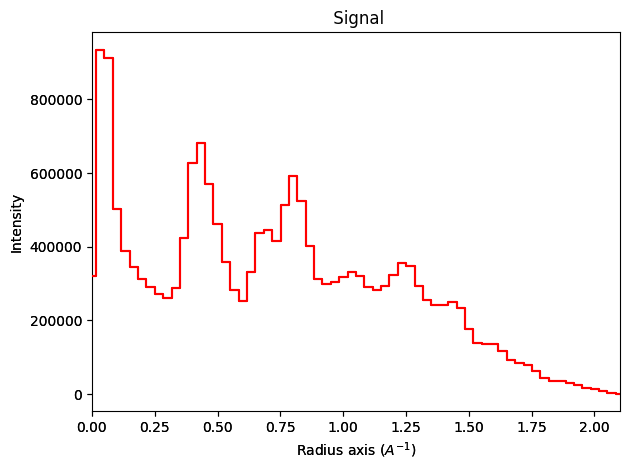

In [8]:
s_rad.max().plot()

Crop in the signal axis to only include the part that we are interested in. This reduces the data size. If you put float numbers in .isig, they refer to calibrated x-axis values, while integers would refer to pixel (uncalibrated) values.

In [9]:
s_rad = s_rad.isig[0.3:1.50]

Plot again and check that the correct signal region has been chosen.

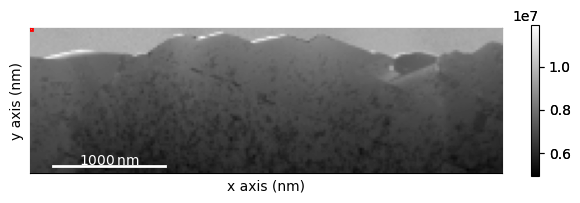

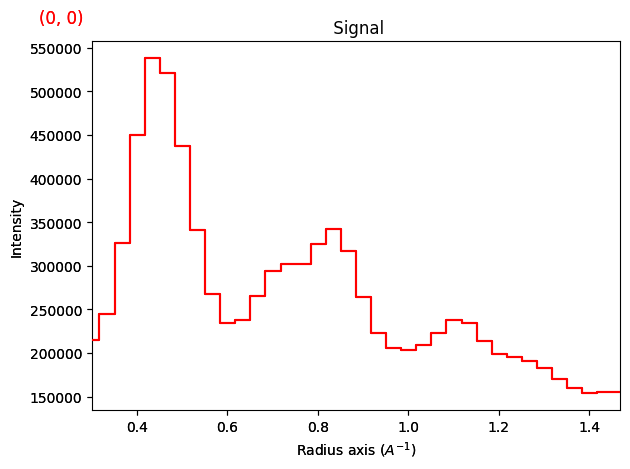

In [10]:
s_rad.plot()

## Decompose the integrated signal

Perform singular value decomposition (SVD) which factorises the data matrix into two new matrices. If the first argument is True, the data will be normalised for Poissonian noise prior to the decomposition. 

For more information, read the documentation here: 
- http://hyperspy.org/hyperspy-doc/current/user_guide/mva/decomposition.html
- https://scikit-learn.org/stable/modules/decomposition.html

In [11]:
t0 = time()
s_rad.decomposition(True)
tf = time()
print('SVD done in ' + str((tf-t0)*1000) + ' ms')

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None
SVD done in 31.248807907104492 ms


Plot the resulting loadings and factors.

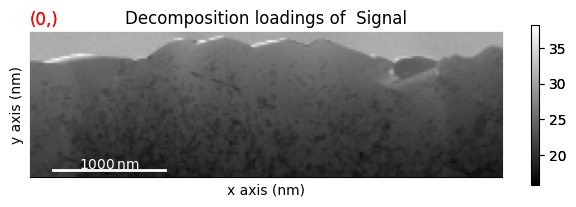

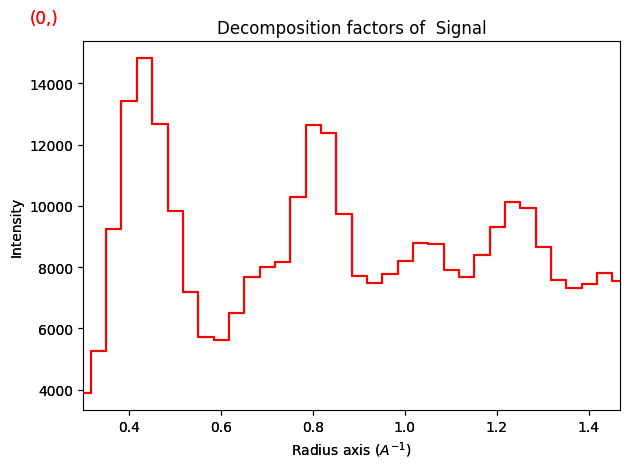

In [12]:
s_rad.plot_decomposition_results()

Plot the 'scree plot', which shows how much of the variance in the dataset each component accounts for.

<Axes: title={'center': '\nPCA Scree Plot'}, xlabel='Principal component index', ylabel='Proportion of variance'>

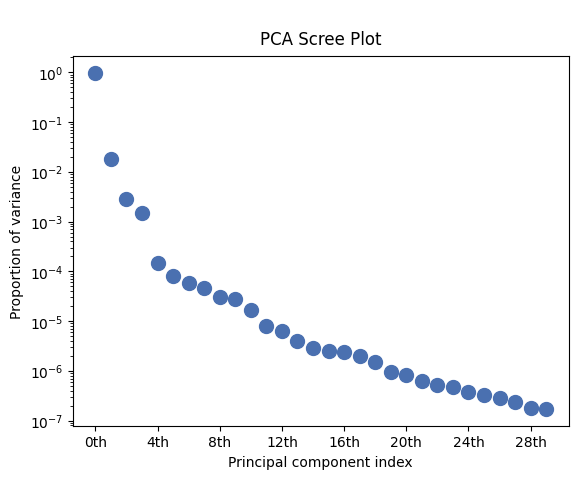

In [13]:
s_rad.plot_explained_variance_ratio()

We can see that at some point the plot starts to decay slowly. This indicates the transistion between components that describe signals and components that describe noise. There is a built-in function that can help us to quantify this "knee" or "elbow" point. This will serve as an initial guess for the number of significant components. If we only save these 4 components, we have reduced the datasize a lot, and so you can use decomposition for dimensionality reduction.

In [14]:
elbow = s_rad.estimate_elbow_position() 
elbow

4

We can plot the scree plot again with the threshold position marked, to check if it looks correct. 

<Axes: title={'center': '\nPCA Scree Plot'}, xlabel='Principal component index', ylabel='Proportion of variance'>

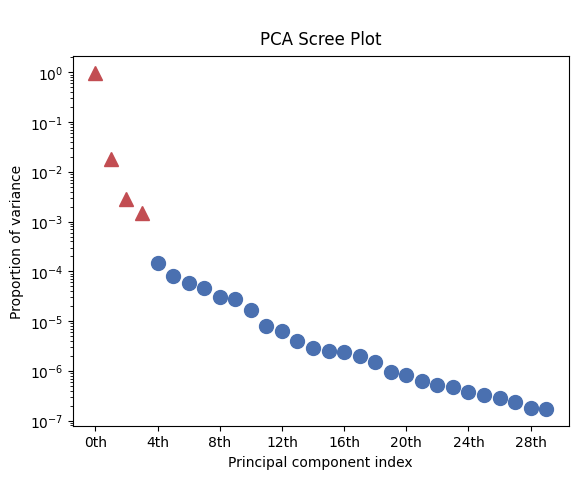

In [15]:
s_rad.plot_explained_variance_ratio(threshold=elbow)

We can reconstruct a dataset based on only the significant components (truncated SVD), excluding all components that account for noise. 

In [16]:
s_rad_decomp = s_rad.get_decomposition_model(elbow)

Define a function that will create markers based on the reconstructed dataset. We also need the calibration and offset value for the integrated dataset (these are not the same as for the original dataset with 2D patterns).

In [17]:
scale = s_rad.axes_manager[2].scale
offset = s_rad.axes_manager[2].offset
s_rad.axes_manager

Navigation axis name,size,index,offset,scale,units
x,208,0,0.0,20.372,nm
y,64,0,0.0,20.372,nm
Signal axis name,size,,offset,scale,units
Radius,36,,0.3003290770645778,0.03336989745161975,$A^{-1}$


In [18]:
def get_marker_offset_signal(sig):
    '''
    Get the signal positions needed to define markers based on the signal.
    
    Parameters
    ----------
    sig: numpy.ndarray
        The signal in one navigation position, as signal.data

    Returns
    ----------
    xys: numpy.ndarray
        The signal positions as [[xi,yi]] in calibrated x-units.
    
    '''
    xys = np.zeros((len(sig), 2))
    for i, sd in zip(range(len(sig)), sig):
        xys[i] = [i*scale+offset, sd]
    return np.array(xys)

Interate over the reconstructed dataset using the map function to extract marker positions for each navigation position. Create markers based on these offset positions. Then plot the integrated dataset with the reconstructed dataset as markers. Inspect how well the reconstructed dataset correspond to the original dataset. 

[########################################] | 100% Completed | 266.01 ms


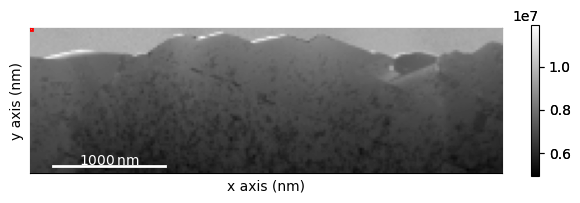

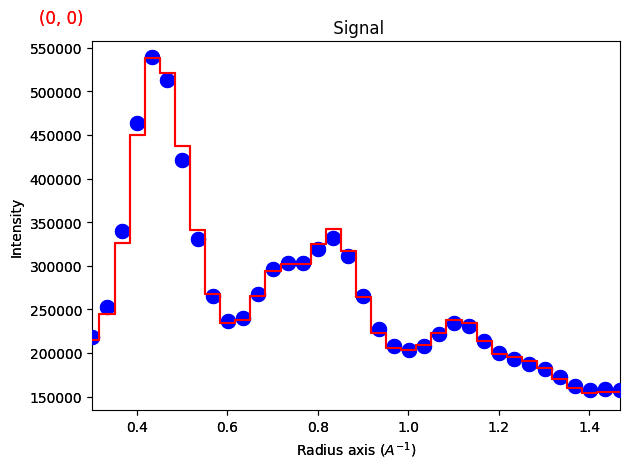

In [19]:
offsets = s_rad_decomp.map(get_marker_offset_signal, inplace=False, ragged=True)
mark = hs.plot.markers.Points(offsets.data.T, color='blue') 
s_rad.plot()
s_rad.add_marker(mark)

It is also possible to plot the dataset, the reconstructed dataset, and the residual, all with the same navigator.

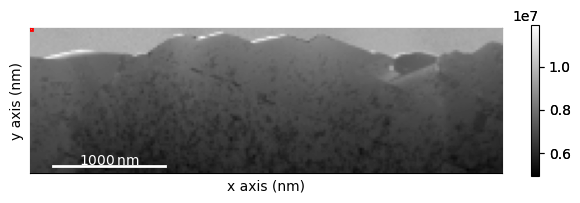

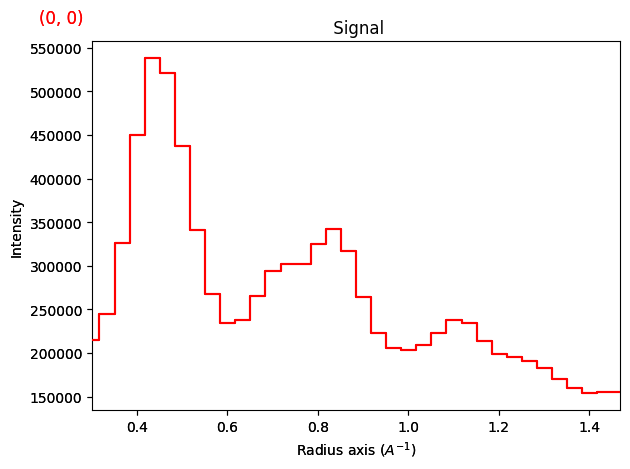

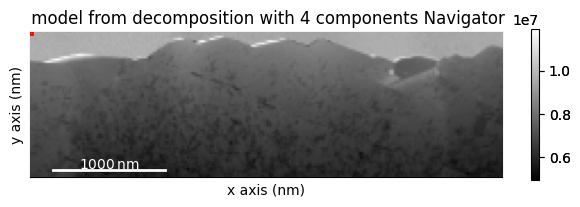

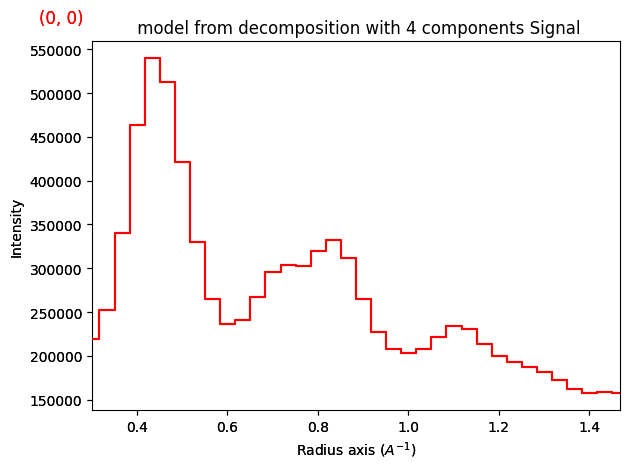

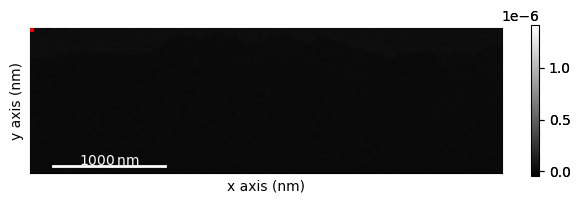

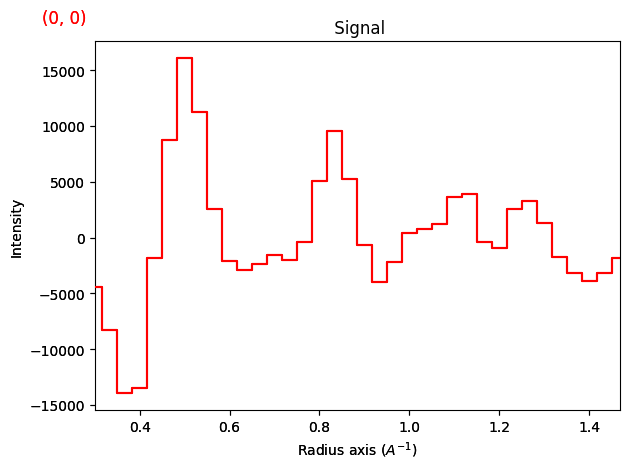

In [20]:
hs.plot.plot_signals([s_rad, s_rad_decomp, (s_rad-s_rad_decomp)], overlay=True)

## Cluster based on the decompositon results

It is possible to use the results of the SVD for blind source separation (BSS) to unmix entangled signals. A fast independent component analysis (ICA) is the default BSS method. 

For information, read the documentation here: 
- http://hyperspy.org/hyperspy-doc/current/user_guide/mva/bss.html
- https://scikit-learn.org/stable/modules/decomposition.html#ica

We want to separate the nanocrystalline region from the silver region and therefore specify two components.

In [21]:
s_rad.blind_source_separation(2)

[########################################] | 100% Completed | 102.65 ms
WARNING | Hyperspy | HyperSpy already performs its own data whitening (whiten_method='PCA'), so it is ignored for algorithm='sklearn_fastica'. (hyperspy.learn.mva:855)


Blind source separation info:
  number_of_components=2
  algorithm=sklearn_fastica
  diff_order=1
  reverse_component_criterion=factors
  whiten_method=PCA
scikit-learn estimator:
FastICA(tol=1e-10, whiten=False)


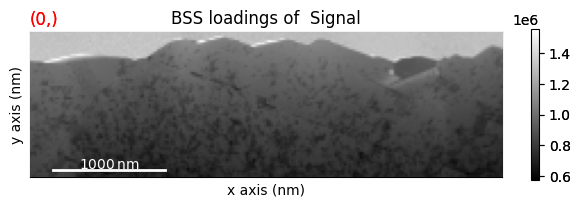

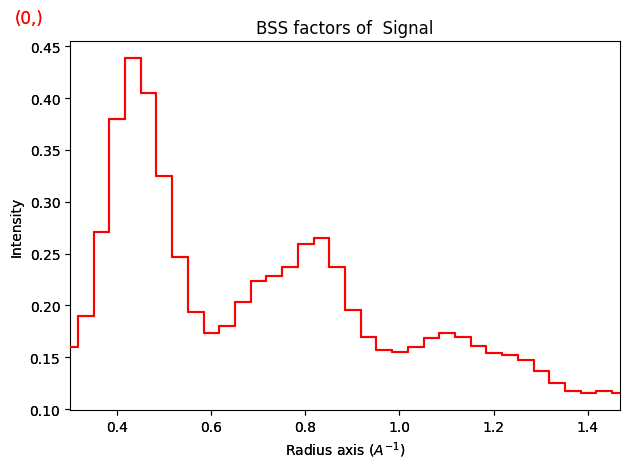

In [22]:
s_rad.plot_bss_results()

The decomposition results can further be used for clustering, i.e. finding groups of similar datapoints. The default clustering method is k-means clustering. We have to specify how many components in the decomposition results to use, and also the number of clusters that we want in the results. 
We can also use cluster_source='decomposition' if we skip the above BSS step. This will also give good results.

For more information: 
- http://hyperspy.org/hyperspy-doc/current/user_guide/mva/clustering.html
- https://scikit-learn.org/stable/modules/clustering.html
- https://scikit-learn.org/stable/modules/clustering.html#k-means

In [23]:
s_rad.cluster_analysis(cluster_source="bss", number_of_components=2, n_clusters=2)

Plot the cluster labels, i.e. the cluster regions in navigation space, and the cluster signals, i.e. the cluster center in signal axis (default is the signal mean calculated within the cluster labels). 

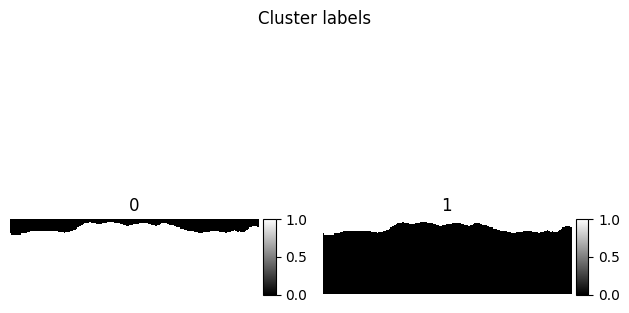

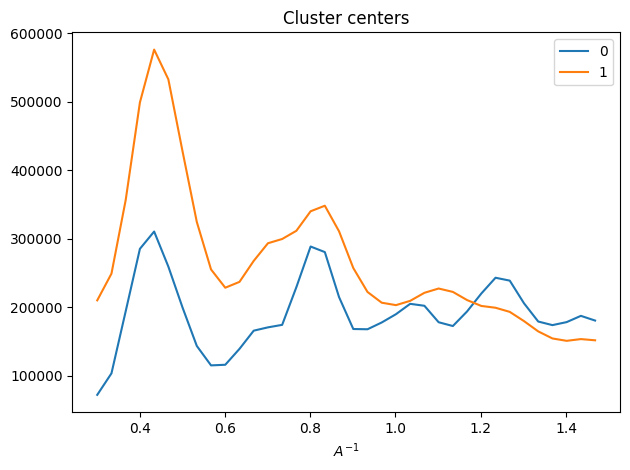

In [24]:
s_rad.plot_cluster_labels(axes_decor="off");
s_rad.plot_cluster_signals();

Extract the labels and use them to create a navigation mask for the nanocrystalline region.

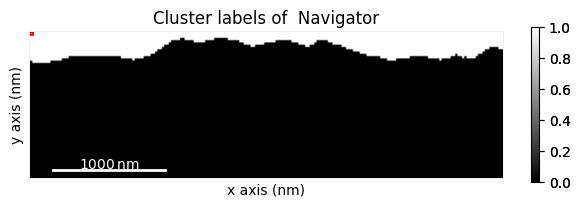

In [25]:
labels = s_rad.get_cluster_labels()
nav_mask = labels.inav[1].T
nav_mask.change_dtype('bool')
nav_mask.plot()

# Decompose the dataset

Now we will go back to working with the original dataset containing 2D patterns. 
First, look at the maximum of the signal to inspect which regions we are interested in. 

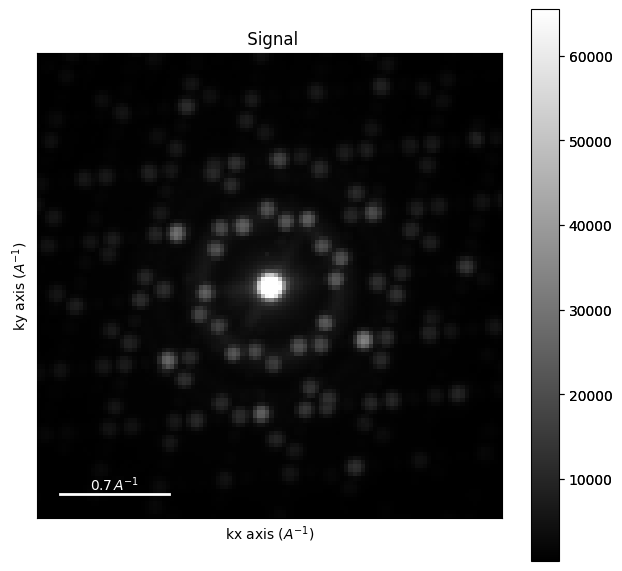

In [26]:
s_max = s.max()
s_max.plot()

We will create a signal mask the excludes the direct beam region, since this typically gives many components in the decomposition later. We will also exclude the region at higher scattering angles, since we have enough information contained within a smaller region. In addition, the regions to higher angles show some deviations from zone axis that would give components that we are not interested in here. 

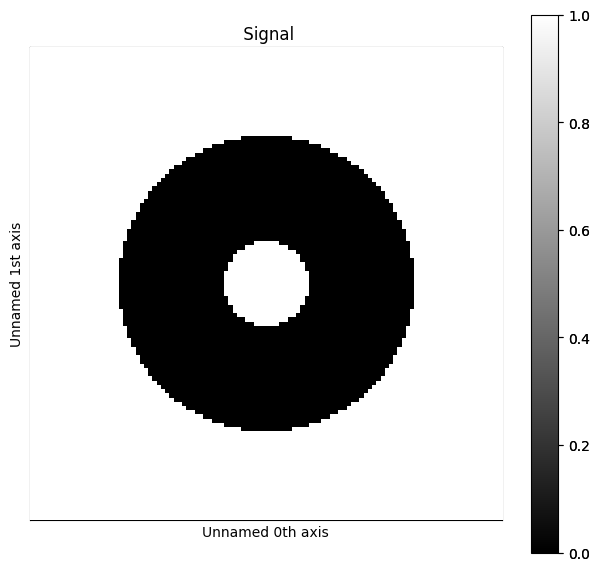

In [27]:
direct_beam_mask0 = s.get_direct_beam_mask(radius=10.)
direct_beam_mask1 = s.get_direct_beam_mask(radius=35.)
direct_beam_mask1.data = ~direct_beam_mask1.data
signal_mask = direct_beam_mask0+direct_beam_mask1
signal_mask.plot()

### Sum Friedel pairs

The next step is optional. It is possible to perform the decomposition on the original dataset. Since we only have zone axis patterns that obey Friedel's law, we can sum the left and right handsides of the patterns to get a smaller dataset prior to the decomposition. This will speed things up and possibly give less components associated with slight deviations from zone axis, so it can help to give decomposition results that are easier to interpret. 

Extract the left and right sides of the patterns and plot them. 

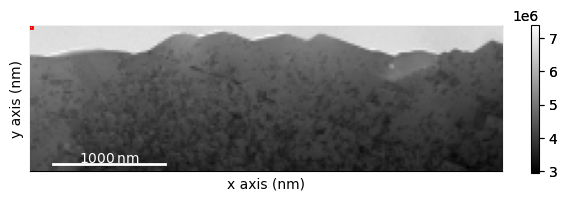

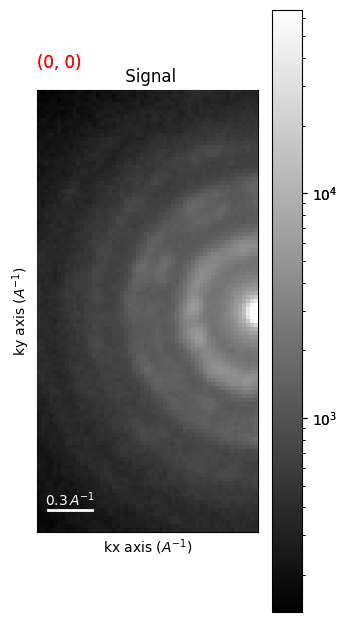

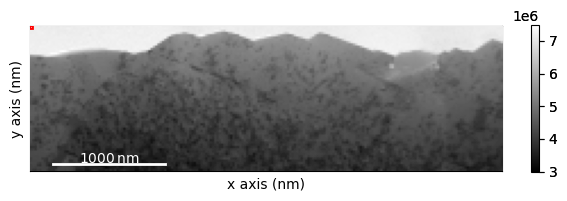

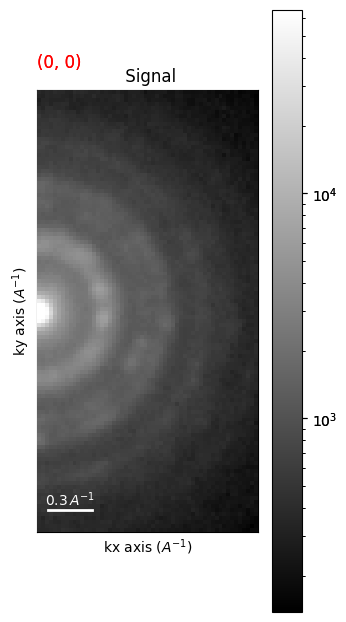

In [28]:
s_left = s.isig[:0., :]
s_right = s.isig[0.:, :]
hs.plot.plot_signals([s_left, s_right], norm='log')

We can then rotate the left side by 180 degrees and inspect that the right and left side now look almost identical. 

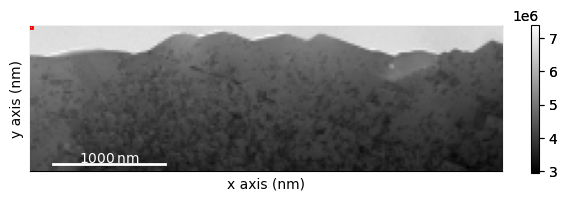

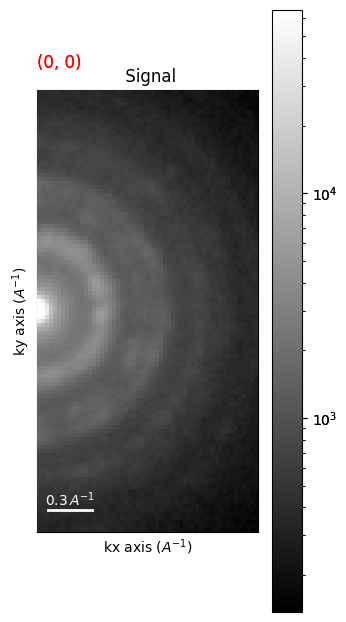

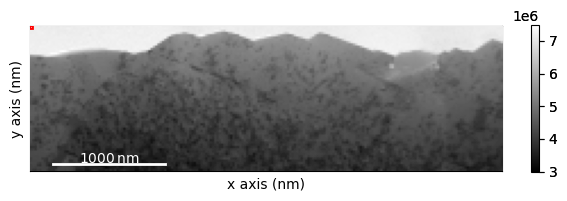

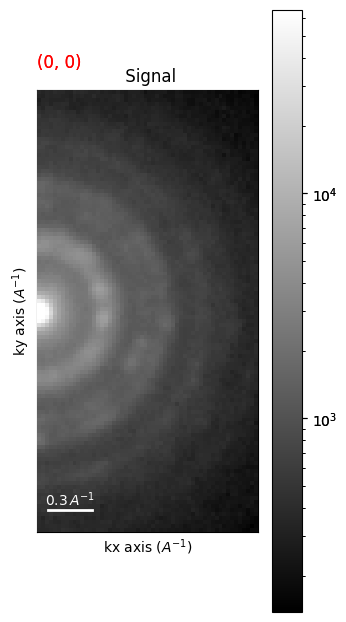

In [29]:
s_left_rot = s_left.rotate_diffraction(180)
hs.plot.plot_signals([s_left_rot, s_right], norm='log')

We can then sum the two sides and inspect the sum. The signal to noise is better, and the data size is smaller!

<ElectronDiffraction2D, title: , dimensions: (208, 64|56, 112)>

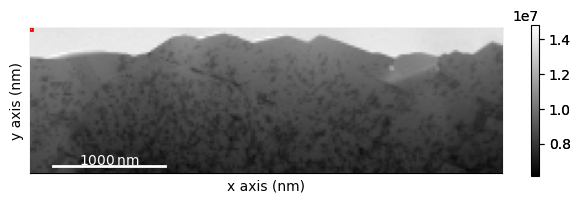

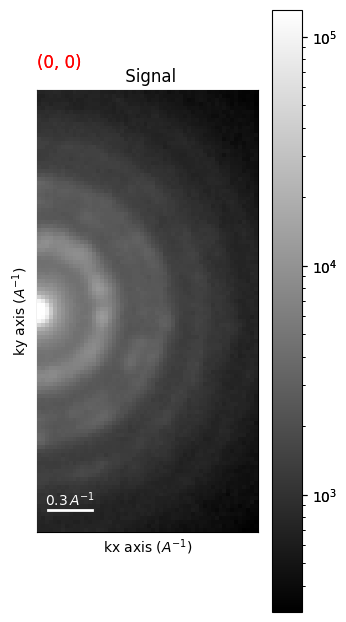

In [30]:
s_rot = s_right + s_left_rot
s_rot.plot(norm='log')
s_rot

We extract only the right side of the signal mask. 

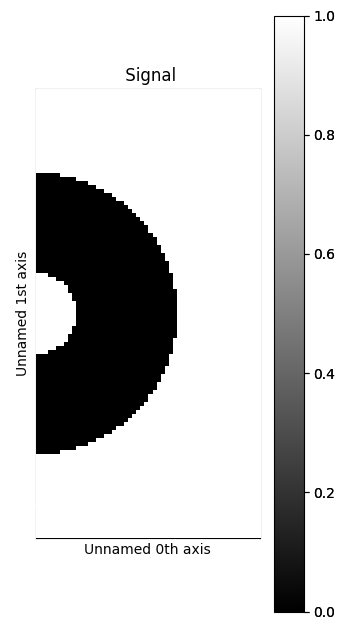

In [31]:
signal_mask_rot = signal_mask.isig[signal_mask.data.shape[0]/2:,:]
signal_mask_rot.plot()

## Decompose the summed signal

Before we can run decomposition, the data type must be converted to floating numbers. 

In [32]:
s_rot.change_dtype('float32')

Perform SVD (same as we did before, see above). We are excluding the regions indicated by the navigation mask (nanocrystalline region) and the signal mask (direct beam region and higher scattering angles). 

In [33]:
t0 = time()
s_rot.decomposition(True, navigation_mask=nav_mask, signal_mask=signal_mask_rot)
tf = time()
print('SVD done in ' + str((tf-t0)) + ' s')

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None
SVD done in 7.312114953994751 s


Plot the results of the decomposition. We see that the silver grains pop up!

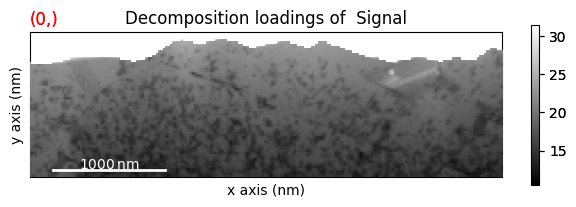

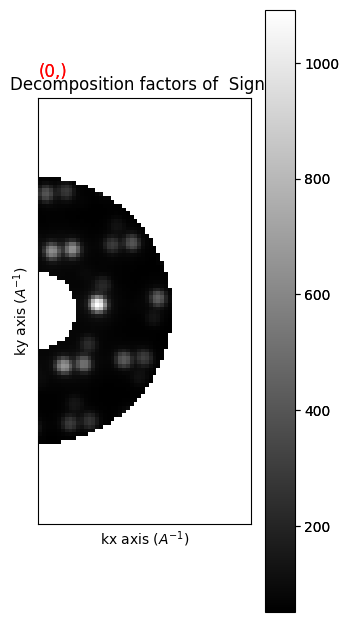

In [34]:
s_rot.plot_decomposition_results()

Estimate the number of significant components and plot the scree plot. We have five unique silver orientations within our dataset and get 6 significant components. We typically get more significant components due to background intensities. If your dataset contains patterns with slight orientation variations, strain etc, the number of significant components will be much higher and harder to estimate...

6

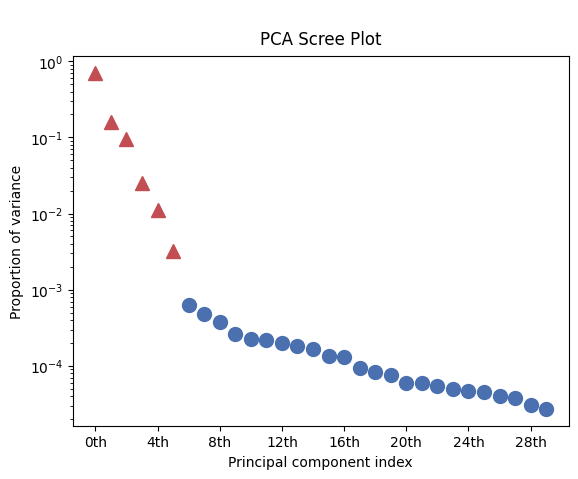

In [35]:
elbow_rot = s_rot.estimate_elbow_position()
s_rot.plot_explained_variance_ratio(threshold=elbow_rot)
elbow_rot

The components from SVD contain both negative and positive values, which make them hard to interpret. We can instead use an iterative matrix decomposition method called non-negative matrix factorisation (NMF) where we use the constraint that all values must be non-negative. This is consistent with the intuitive notion that you add parts together to form a whole, and it typically gives components that resembles the original signal (diffraction patterns and virtual images) to a much higher degree. It is an interative method, so we have to supply an initial guess. The default is to base the initial guess on an SVD, which by experience gives the best results. 

For more information: 
- http://hyperspy.org/hyperspy-doc/current/user_guide/mva/decomposition.html#non-negative-matrix-factorization-nmf
- https://scikit-learn.org/stable/modules/decomposition.html#non-negative-matrix-factorization-nmf-or-nnmf

In [36]:
t0 = time()
s_rot.decomposition(True, 'NMF', elbow_rot, navigation_mask=nav_mask, signal_mask=signal_mask_rot)
tf = time()
print('NMF done in ' + str((tf-t0)) + ' s')

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=6
  centre=None
scikit-learn estimator:
NMF(n_components=6)
NMF done in 5.408527612686157 s


C:\Anaconda\envs\pyxem-git-repo\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Extract the factors and loadings and plot them with the same navigator. The loadings resemble virtual images of the silver grains, while the factors resemble the average silver pattern within those grains. 

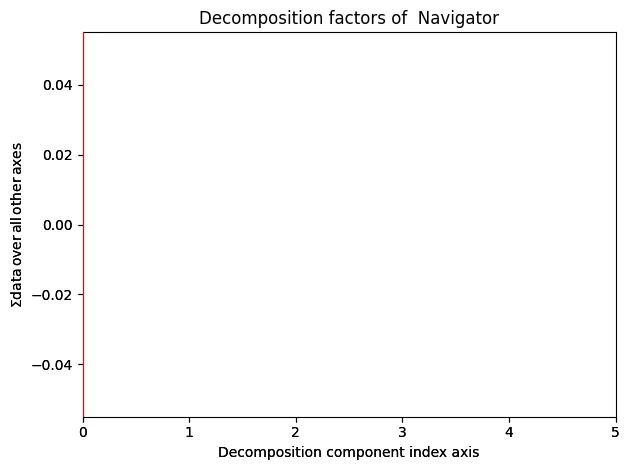

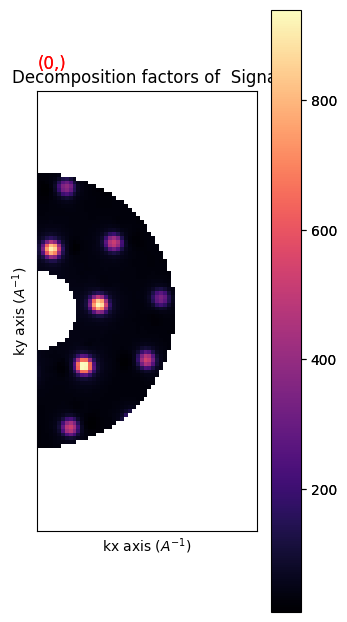

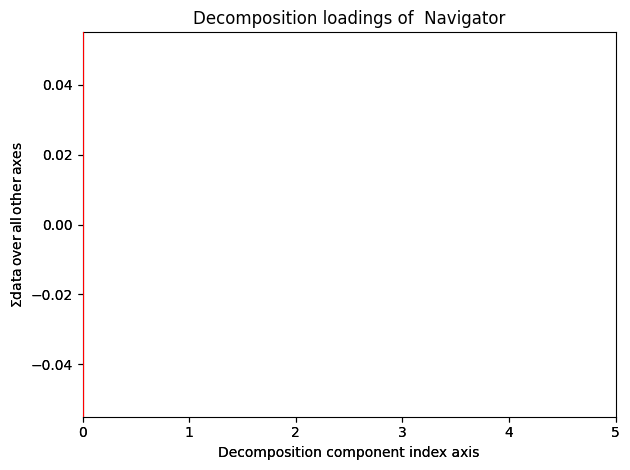

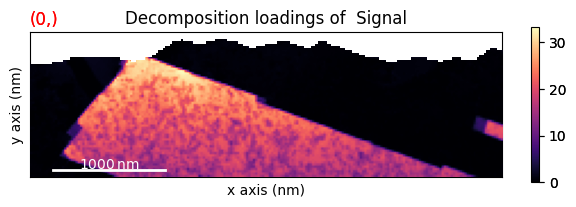

In [37]:
factors = s_rot.get_decomposition_factors()
loadings = s_rot.get_decomposition_loadings()
hs.plot.plot_signals([factors, loadings], cmap='magma')

## Cluster based on NMF

We cluster the NMF results to get binary masks covering each of the silver grains. We specify five clusters corresponding to the five unique silver grains. We use the same signal and navigation masks as before.

In [38]:
s_rot.cluster_analysis(
    cluster_source="decomposition", number_of_components=5, 
    navigation_mask=nav_mask.data, signal_mask=signal_mask_rot, n_clusters=5)

Plot the clustering results. First, the labels.

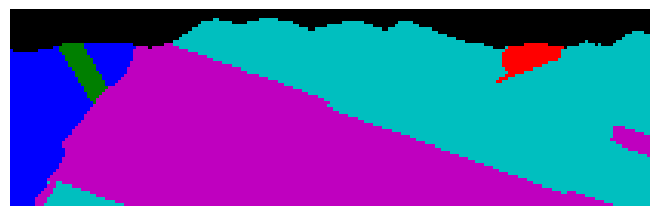

In [39]:
labels = s_rot.get_cluster_labels()
hs.plot.plot_images([labels.inav[i] for i in range(5)], overlay=True, axes_decor='off', label=None);

Then plot the mean signal within each cluster.

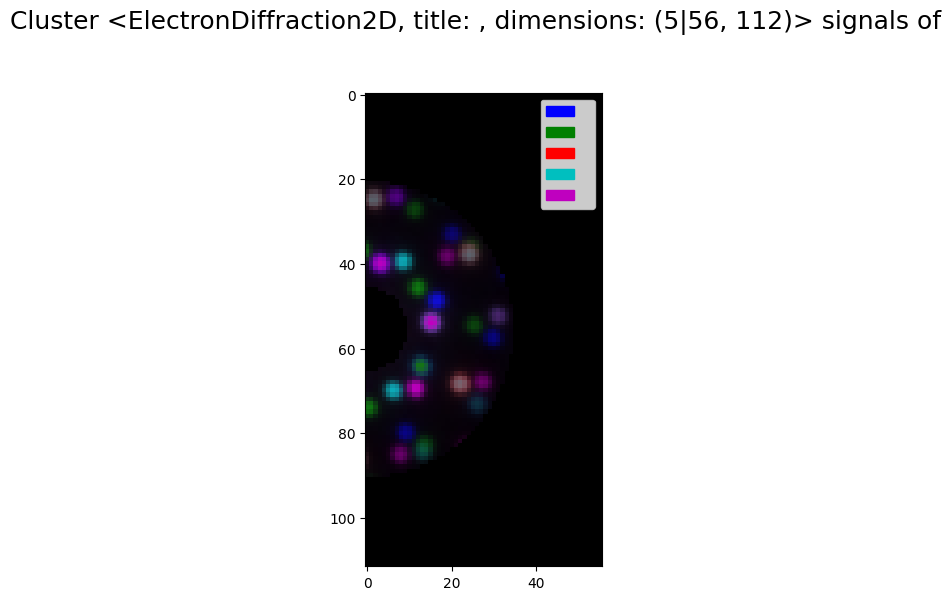

In [40]:
cluster_sigs = s_rot.get_cluster_signals()
cluster_sigs.data = np.nan_to_num(cluster_sigs.data)
hs.plot.plot_images([cluster_sigs.inav[i] for i in range(5)], overlay=True);

Save the labels.

In [41]:
labels.save(folder+file+'_labels.hspy', overwrite=True)

Sum the original signal within the labels. We will do this using the map function and therefore define our own function for summing.

In [42]:
def sum_signal_in_label(label):
    return np.sum(s.data[label], axis=(0))

In [43]:
labels_sum_signal = labels.map(sum_signal_in_label, inplace=False)
labels_sum_signal = pxm.signals.ElectronDiffraction2D(labels_sum_signal)
labels_sum_signal

[########################################] | 100% Completed | 305.25 ms


<ElectronDiffraction2D, title: , dimensions: (5|112, 112)>

We set the diffraction calibration based on the original dataset

In [44]:
labels_sum_signal.set_diffraction_calibration(s.axes_manager[3].scale)

In [45]:
labels_sum_signal.axes_manager

Navigation axis name,size,index,offset,scale,units
,5,0,0.0,1.0,
Signal axis name,size,,offset,scale,units
kx,112,,-1.4967850176908926,0.02672830388733737,$A^{-1}$
ky,112,,-1.4967850176908926,0.02672830388733737,$A^{-1}$


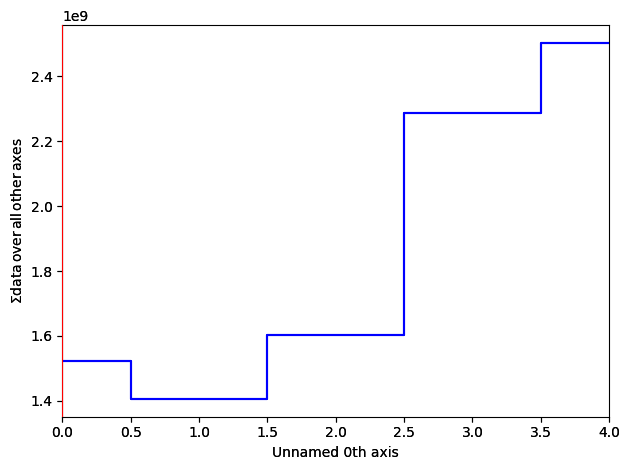

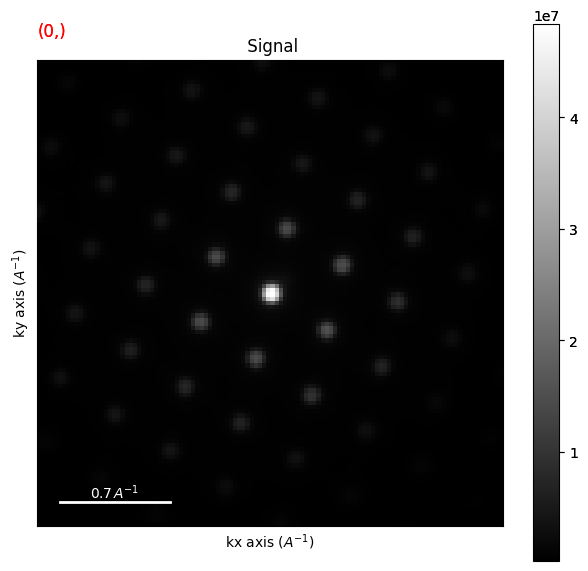

In [46]:
labels_sum_signal.plot()

Save the summed signal within each cluster. We will use these as a staring point for the next session!!

In [47]:
labels_sum_signal.save(folder+file+'_labels_sum_signal.hspy', overwrite=True)

## Perform NMF with more components
If we inspect the dataset, we see that we have many more spots than those picked up by the NMF using only 6 components. In the overlap regions, we get double diffraction giving these extra spots. Where did they go? If a signal in your dataset is not accounting for a large protion of the variance in the whole dataset, this signal can go unnoticed in the decomposition. It is not trivial to find the best number of components for your dataset, and great care must be taken!

In [48]:
t0 = time()
s_rot.decomposition(True, 'NMF', 20, navigation_mask=nav_mask, signal_mask=signal_mask_rot)
tf = time()
print('NMF done in ' + str((tf-t0)) + ' s')

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=20
  centre=None
scikit-learn estimator:
NMF(n_components=20)
NMF done in 5.895984411239624 s


C:\Anaconda\envs\pyxem-git-repo\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Plot the results and see if you can find the double diffraction spots now...

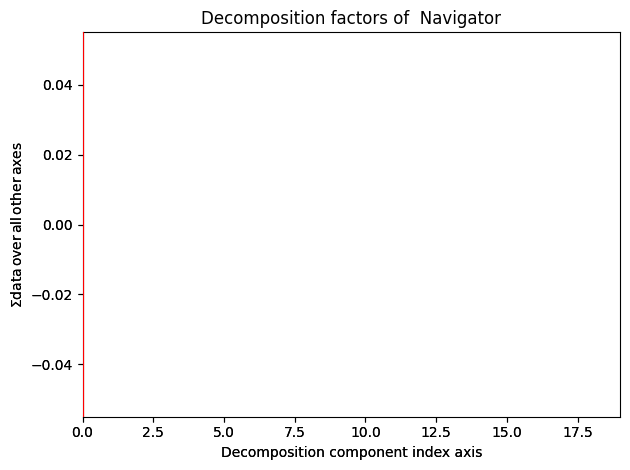

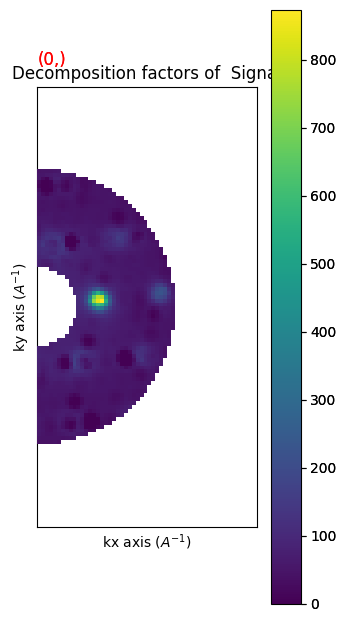

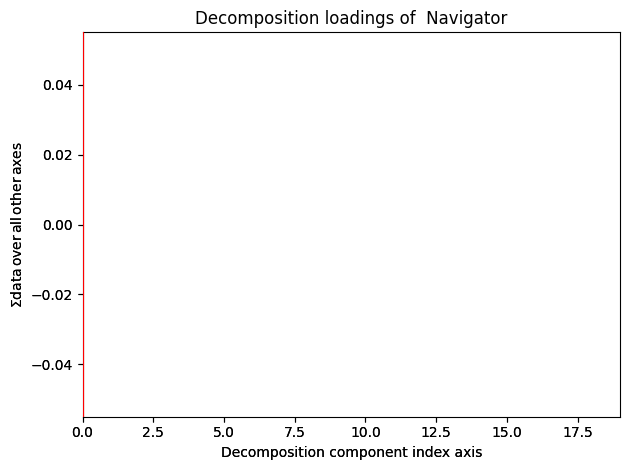

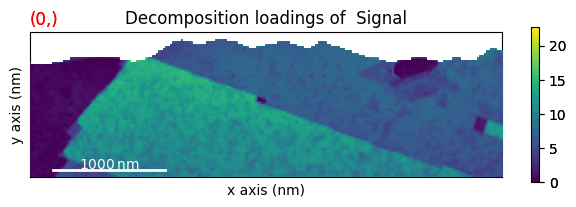

In [49]:
factors_rot_NMF20 = s_rot.get_decomposition_factors()
loadings_rot_NMF20 = s_rot.get_decomposition_loadings()
hs.plot.plot_signals([factors_rot_NMF20, loadings_rot_NMF20], cmap='viridis')